Lecture: AI I - Advanced 

Previous:
[**Chapter 2.2: Hyperparameter Tuning**](../02_training/02_optimization.ipynb)

---

# Chapter 2.3: Ensemble Learning

In the previous section, you used Optuna to find the single best hyperparameter configuration—one optimal architecture, one optimal learning rate, one optimal dropout rate. This approach assumes there's a "perfect" model waiting to be discovered. But what if instead of searching for one perfect model, you could combine multiple good models to make even better predictions?

This is the core idea behind **ensemble learning**: rather than relying on a single model's judgment, you create a committee of models that vote or average their predictions. Just as a panel of experts often makes better decisions than any individual expert, an ensemble of neural networks can outperform even the best individual model.

## What is Ensemble Learning?

**Ensemble learning** is the technique of combining predictions from multiple models to produce a final prediction that is typically more accurate and robust than any individual model. It's one of the most powerful techniques in machine learning—ensemble methods consistently win Kaggle competitions and are widely used in production systems.


### Why Ensembles Work: The Wisdom of Crowds

Imagine you ask 5 different doctors to diagnose a patient. Each doctor has been trained differently, has different experiences, and might notice different symptoms. If 4 out of 5 doctors agree on a diagnosis, you'd probably trust that more than any single doctor's opinion.

Neural networks work the same way. Different models make different mistakes because they:
- Start from different random weight initializations
- See training data in different orders (due to shuffling)
- Have different architectures (funnel vs. brick shape)
- Use different regularization (different dropout patterns)

When you combine their predictions, the errors tend to cancel out while the correct predictions reinforce each other.

For ensembles to work well, the individual models must be diverse—they should make different kinds of errors. If all models make the exact same mistakes, combining them won't help. This is why we'll train models with different architectures and random initializations.

### Types of Ensemble Methods

**1. Model Averaging (Regression)** For regression tasks, simply average the predictions:

$$y^{ensemble} = \frac{1}{M} \sum_{i=1}^{M} y^i$$

**2. Majority Voting (Classification)** Each model votes for a class, and the class with the most votes wins:

$$\hat{y}_{\text{ensemble}} = \text{argmax}_c \sum_{i=1}^{M} \mathbb{1}[\hat{y}_i = c]$$

There are more sophisticated methods like weighted voting, stacking, and boosting, but averaging and majority voting are simple and effective starting points.

## Ensemble Learning Example

In [1]:
import torch

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

iris = datasets.load_iris()
x = iris.data  # 4 features: sepal length, sepal width, petal length, petal width
y = iris.target  # 3 classes: setosa, versicolor, virginica

x_scaled = StandardScaler().fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_scaled, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val)), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test)), batch_size=batch_size)

### Funnel Architecture

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class FunnelNetwork(nn.Module):
    """
    Funnel architecture: Wide → Narrow
    Starts with many neurons and gradually reduces.
    Good for learning broad features then focusing.
    """
    def __init__(self, input_dim=4, output_dim=3):
        super().__init__()
        # 128 → 64 → 32 (funnel shape)
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Inverted Funnel Architecture

In [6]:
class InvertedFunnelNetwork(nn.Module):
    """
    Inverted Funnel architecture: Narrow → Wide
    Starts focused and gradually expands representation.
    Builds increasingly complex features.
    """
    def __init__(self, input_dim=4, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Brick Architecture

In [3]:
class BrickNetwork(nn.Module):
    """
    Brick architecture: Constant width
    All hidden layers have the same number of neurons.
    Good for maintaining consistent representation.
    """
    def __init__(self, input_dim=4, output_dim=3):
        super().__init__()
        # 64 → 64 → 64 (brick/constant shape)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Training

In [10]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    return train_loss / len(train_loader.dataset), correct / total


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            eval_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    return eval_loss / len(data_loader.dataset), correct / total


def train_model(model, train_loader, val_loader, num_epochs=150, lr=0.01):
    """Train a single model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    best_val_acc = 0.0
    patience = 20
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_val_acc

In [11]:
models = {
    "Funnel": FunnelNetwork(),
    "Inverted Funnel": InvertedFunnelNetwork(),
    "Brick": BrickNetwork()
}

for name, model in models.items():
    best_val_acc = train_model(model, train_loader, val_loader)
    print(f"{name} Best Validation Accuracy: {best_val_acc:.4f}")

Funnel Best Validation Accuracy: 0.9667
Inverted Funnel Best Validation Accuracy: 1.0000
Brick Best Validation Accuracy: 0.9667


### Implement Hard Majority Voting

In [12]:
import numpy as np

def predict_majority_voting(models, X):
    """
    Hard majority voting: Each model votes for a class, majority wins.
    """
    votes = []
    
    # Collect votes from each model
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            votes.append(predicted.numpy())
    
    # votes shape: (n_models, n_samples)
    votes = np.array(votes)
    
    # Majority voting for each sample
    ensemble_predictions = []
    for i in range(votes.shape[1]):
        # Get votes for this sample from all models
        sample_votes = votes[:, i]
        # Find most common prediction (mode)
        prediction = np.bincount(sample_votes).argmax()
        ensemble_predictions.append(prediction)
    
    return np.array(ensemble_predictions)

### Evaluation

In [23]:
from sklearn.metrics import classification_report

y_pred = predict_majority_voting(models.values(), torch.FloatTensor(x_test))

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



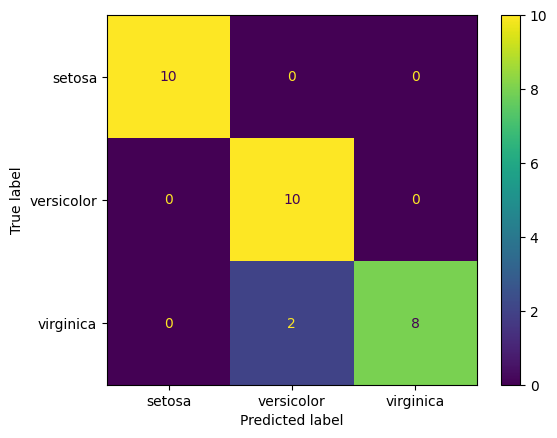

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=iris.target_names)

---

Lecture: AI I - Basics 

Exercise: [**Exercise 2.3: Ensemble Learning**](../02_training/exercises/03_ensemble.ipynb)

Next: [**Chapter 3.1: PyTorch Lightning**](../03_advanced/01_ligthning.ipynb)